# SCP Dataset Exploration and Visualizations
## Overview
This file was created to explore various visualizations of the SCP dataset in order to select interesting visualizations for the SCP Status dashboard.
## Setup

In [68]:
#!pip install pandas
#!pip install matplotlib
#!pip install dash
#!pip install plotly

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import re
import plotly.graph_objects as go
import plotly.express as px

In [100]:
df = pd.read_csv("scp6999augmented.csv")

## Visualizations
### Object classes

In [102]:
primary_classes=["Safe", "Euclid", "Keter"]
primary_classes_df = df[df["class"].isin(primary_classes)]

In [103]:
class_counts = primary_classes_df.groupby(["class", "series"]).count().reset_index()

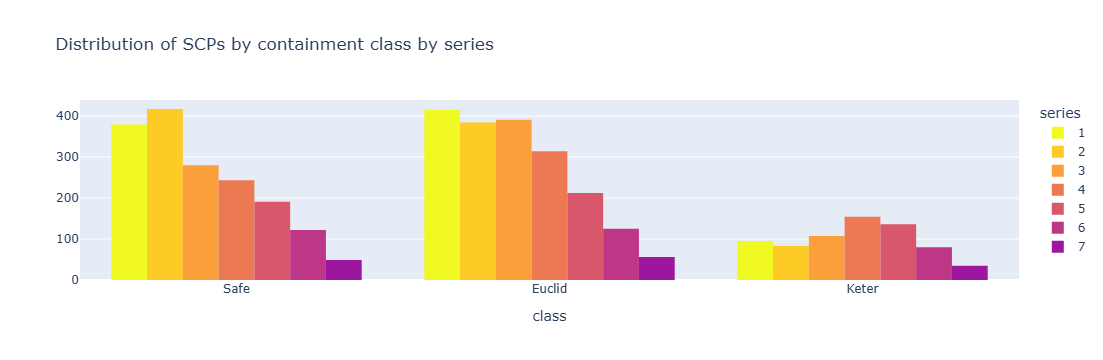

In [104]:
fig = px.histogram(class_counts, x="class", y="code", color="series", color_discrete_sequence=px.colors.sequential.Plasma_r, barmode="group",
                  title="Distribution of SCPs by containment class by series")
fig.update_xaxes(categoryorder="array", categoryarray=primary_classes)
fig.update_layout(yaxis_title="")
fig.update_traces(hovertemplate='Total SCPs: %{y}<extra></extra>')
fig.show()

## SCP mentions in other articles

In [106]:
top10 = df.sort_values(by='mentions', ascending=False).head(10)

In [110]:
top10[["code", "mentions"]]

,code,mentions
616,SCP-617,1003
457,SCP-458,783
605,SCP-606,754
299,SCP-300,733
478,SCP-479,703
501,SCP-502,697
499,SCP-500,696
309,SCP-310,691
444,SCP-445,687
300,SCP-301,682


## █ per article

In [195]:
def contains_count(string, elements):
    count = 0
    for element in elements:
        count += string.count(element)
    return count

In [197]:
black_df = df
black_df["black rectangles"] = black_df.apply(lambda row: contains_count(row["text"], ["█"]), axis=1)

In [227]:
topclasses = pd.DataFrame(df["class"].value_counts()).head(3).reset_index()
tclist = topclasses["class"].tolist()

In [229]:
tc_scps = black_df["class"].isin(tclist)
black_df = black_df[tc_scps]

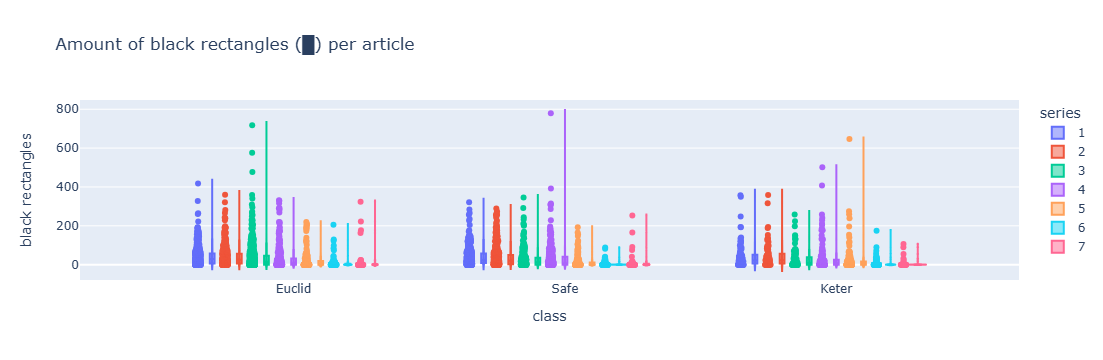

In [231]:
figure=px.violin(
            black_df,
            y="black rectangles",
            x="class",
            color="series",
            box=True,
            points="all",
            hover_data={"code":True, "title":True, "class": False, "series": False},
            title = "Amount of black rectangles (█) per article"
        )
figure.show()

Index(['Unnamed: 0', 'code', 'title', 'text', 'image captions', 'rating',
       'state', 'tags', 'link', 'class type', 'class', 'series', 'mentions',
       'black rectangles'],
      dtype='object')